## << 문제 정의 >>

글로벌 쇼핑몰의 클릭 로그 데이터를 분석하여, 어떤 유저가 어떤 아이템을 클릭하는지 확인하고 싶습니다.
주어진 데이터는 해당 쇼핑몰의 2024년 4월 1일부터 2024년 5월 7일까지의 클릭 로그 데이터입니다.

2024년 4월 1일부터 4월 30일까지의 데이터를 학습하여, 그 이후 일주일간 각 아이템을 클릭하는지 안하는지를 예측하는 문제를 풀어보세요.

자세한 대회 관련 사항은 아래 대회 페이지를 참조하세요.

[Competition Page]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
import xgboost as xgb
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(42)  # 무조건 42로 세팅!!

In [106]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
train.shape, test.shape, submission.shape

# order 값별로 Clicked가 1인 개수와 0인 개수를 계산
order_clicked_counts = train.groupby(['page', 'Clicked']).size().unstack(fill_value=0)

# 비율 계산 (Clicked=1의 비율)
order_clicked_counts['Total'] = order_clicked_counts[0] + order_clicked_counts[1]
order_clicked_counts['Clicked_1_Ratio'] = (order_clicked_counts[1] / order_clicked_counts['Total']) * 100
order_clicked_counts['Clicked_0_Ratio'] = (order_clicked_counts[0] / order_clicked_counts['Total']) * 100

# 소수점 둘째 자리까지 반올림
order_clicked_counts['Clicked_1_Ratio'] = order_clicked_counts['Clicked_1_Ratio'].round(2)
order_clicked_counts['Clicked_0_Ratio'] = order_clicked_counts['Clicked_0_Ratio'].round(2)

pd.set_option('display.max_rows', None)
print(order_clicked_counts)
pd.reset_option('display.max_rows')
#display(train)









train = train.dropna(subset=['page 1 (main category)'])


train['page_category'] = 3  # 기본값: Bottom
train.loc[train['page'] == 1, 'page_category'] = 1 # Top
train.loc[(train['page'] >= 2) & (train['page'] <= 4), 'page_category'] = 2  # Middle

# page_category를 숫자형으로 변환
train['page_category'] = train['page_category'].astype(int)
train = train.drop(columns=['page'])



Clicked      0      1  Total  Clicked_1_Ratio  Clicked_0_Ratio
page                                                          
1        15986  11203  27189            41.20            58.80
2         8774   3518  12292            28.62            71.38
3         4005   1693   5698            29.71            70.29
4         1721    646   2367            27.29            72.71
5          516    137    653            20.98            79.02


In [35]:
train.isnull().sum()

,0
click_id,0
date,0
order,0
country,0
session ID,0
page 1 (main category),0
page 2 (clothing model),2135
colour,0
location,0
model photography,0


In [107]:

train = train.dropna(subset=['page 1 (main category)'])
train.isnull().sum()

train_data = train.dropna(subset=['page 2 (clothing model)'])

# 예측할 데이터 (결측치가 있는 행)
predict_data = train[train['page 2 (clothing model)'].isna()]

# 범주형 변수 인코딩 (Label Encoding)
for col in ['page 1 (main category)', 'colour', 'location', 'model photography', 'country', 'order']:
    train_data[col] = train_data[col].astype(str)
    predict_data[col] = predict_data[col].astype(str)

# 특징 변수와 타겟 변수
X = train_data[['page 1 (main category)', 'colour', 'location', 'model photography', 'price', 'country', 'order', 'page_category']]
y = train_data['page 2 (clothing model)']

# 예측에 사용할 데이터
X_predict = predict_data[['page 1 (main category)', 'colour', 'location', 'model photography', 'price', 'country', 'order', 'page_category']]

# 학습/검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 (랜덤 포레스트)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 검증
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print(f"모델 정확도: {accuracy:.4f}")

# 결측치 예측
predictions = model.predict(X_predict)

# 결측치 채우기
train.loc[train['page 2 (clothing model)'].isna(), 'page 2 (clothing model)'] = predictions

# 결과 확인
print(train['page 2 (clothing model)'].isna().sum())

# 채워진 데이터 저장
train.to_csv("filled_click_data.csv", index=False)
#train['page 2 (clothing model)'] = train['page 2 (clothing model)'].fillna(train['page 2 (clothing model)'].mode().values[0])
#train.info()

#0.9033

모델 정확도: 0.9033
0


In [108]:
train['page 2 (clothing model)'] = pd.factorize(train['page 2 (clothing model)'])[0]
train.isnull().sum()


train['location_category'] = 0  # 기본값
# Group 1 (1, 2, 3)
train.loc[train['location'].isin([1, 2, 3]), 'location_category'] = 1

# Group 2 (4, 6)
train.loc[train['location'].isin([4, 6]), 'location_category'] = 2

# Group 3 (5)
train.loc[train['location'] == 5, 'location_category'] = 3

train = train.drop(columns=['location'])



train['order_category'] = 0  # 기본값

# 0 ~ 25% → Group 1
train.loc[train['order'].isin([38, 42, 44, 46, 47, 48, 50, 57, 59, 63, 70, 72, 73, 74, 75, 76, 80, 84, 85, 96, 97, 98, 104, 106, 107, 108, 109, 110, 111]), 'order_category'] = 1

# 25 ~ 32% → Group 2
train.loc[train['order'].isin([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 49, 54, 61, 65, 71, 81, 82, 83, 89]), 'order_category'] = 2

# 32 ~ 40% → Group 3
train.loc[train['order'].isin([1, 2, 43, 45, 51, 52, 53, 56, 58, 60, 62, 66, 67, 69, 78, 79, 86, 90, 94]), 'order_category'] = 3

# 40% 이상 → Group 4
train.loc[train['order'].isin([3, 4, 5, 6, 55, 64, 68, 77, 87, 88, 91, 92, 93, 95, 99, 100, 101, 102, 103, 105, 112]), 'order_category'] = 4


train = train.drop(columns=['order'])


train['colour_category'] = 0  # 기본값
# 0 ~ 25% → Group 1
train.loc[train['colour'].isin([5, 6]), 'colour_category'] = 1

# 25 ~ 32% → Group 2
train.loc[train['colour'].isin([1, 9, 10, 11, 12, 13]), 'colour_category'] = 2

# 32 ~ 40% → Group 3
train.loc[train['colour'].isin([2, 4, 7, 14]), 'colour_category'] = 3

# 40% 이상 → Group 4
train.loc[train['colour'].isin([3, 8]), 'colour_category'] = 4


train = train.drop(columns=['colour'])




train['main category'] = 0  # 기본값
# 0 ~ 25% → Group 1
train.loc[train['page 1 (main category)'].isin([2.0]), 'main category'] = 1

# 25 ~ 32% → Group 2
train.loc[train['page 1 (main category)'].isin([1.0, 3.0]), 'main category'] = 2

# 32 ~ 40% → Group 3
train.loc[train['page 1 (main category)'].isin([4.0]), 'main category'] = 3


train = train.drop(columns=['page 1 (main category)'])




train['clothing category'] = 0  # 기본값
# 0 ~ 25% → Group 1
train.loc[train['page 2 (clothing model)'].isin([9, 57, 73, 89]),'clothing category'] = 1

# 25 ~ 32% → Group 2
train.loc[train['page 2 (clothing model)'].isin([11, 39, 48, 58]), 'clothing category'] = 2

# 32 ~ 40% → Group 3
train.loc[train['page 2 (clothing model)'].isin([0, 1, 2, 13, 20, 29, 30, 47, 74, 77, 86, 90, 102, 126]), 'clothing category'] = 3

# 25 ~ 32% → Group 2
train.loc[train['page 2 (clothing model)'].isin([46, 49, 53, 75, 76, 83, 88, 111]), 'clothing category'] = 4

# 25 ~ 32% → Group 2
train.loc[train['page 2 (clothing model)'].isin([52, 54, 71]), 'clothing category'] = 5

# 25 ~ 32% → Group 2
train.loc[train['page 2 (clothing model)'].isin([14, 127]), 'clothing category'] = 6


train = train.drop(columns=['page 2 (clothing model)'])






train


,click_id,date,country,session ID,model photography,price,Clicked,page_category,location_category,order_category,colour_category,main category,clothing category
0,1,2024-04-01,29,1,1,39.0,1,1,3,3,2,2,3
1,2,2024-04-01,29,1,1,40.0,0,1,2,3,2,2,3
2,3,2024-04-01,29,1,1,46.0,1,1,1,4,2,1,3
3,4,2024-04-01,29,1,2,30.0,0,1,2,4,1,1,0
4,5,2024-04-01,29,1,2,41.0,0,1,1,4,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48194,48195,2024-04-30,29,6940,2,39.0,0,2,3,1,1,1,0
48195,48196,2024-04-30,29,6940,1,46.0,0,2,2,2,3,1,0
48196,48197,2024-04-30,29,6940,1,49.0,1,1,1,2,3,3,0
48197,48198,2024-04-30,29,6940,2,49.0,0,3,1,2,2,3,0


요인
필요 없는 것
click_id,

가공 할 것
1. date를 버리지 말고 주말 평일 or 요일 별로

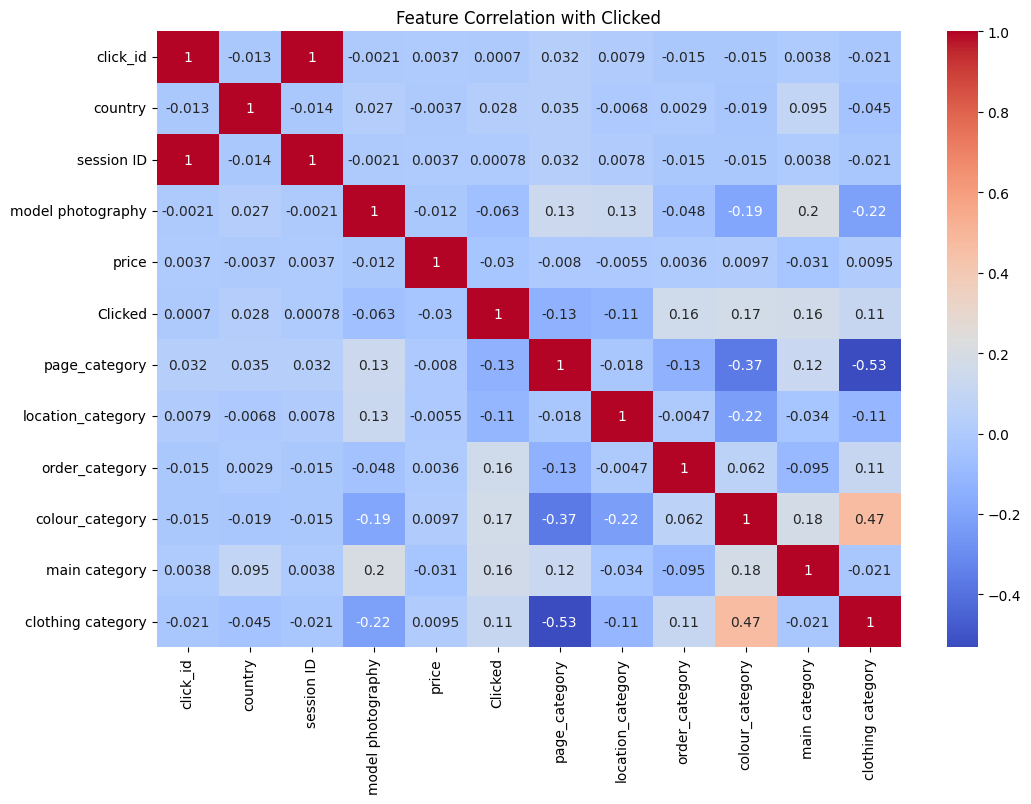

Clicked와의 상관계수:
Clicked              1.000000
colour_category      0.170416
main category        0.163088
order_category       0.157374
clothing category    0.109713
country              0.027506
session ID           0.000781
click_id             0.000703
price               -0.029675
model photography   -0.063492
location_category   -0.114227
page_category       -0.132145
Name: Clicked, dtype: float64


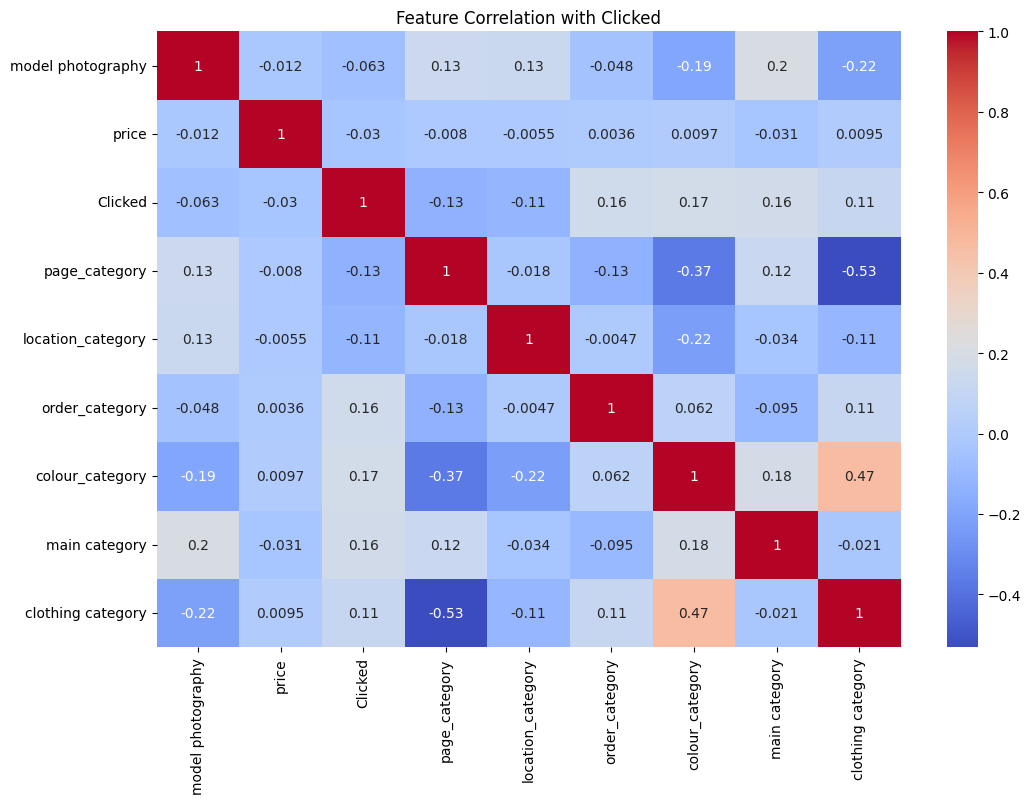

Clicked와의 상관계수:
Clicked              1.000000
colour_category      0.170416
main category        0.163088
order_category       0.157374
clothing category    0.109713
price               -0.029675
model photography   -0.063492
location_category   -0.114227
page_category       -0.132145
Name: Clicked, dtype: float64
(38534, 8) (9634, 8) (38534,) (9634,)


In [110]:
train

correlation = train.drop(columns=['date']).corr()

# 상관계수 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Clicked")
plt.show()

# Clicked와의 상관관계 정렬
clicked_corr = correlation['Clicked'].sort_values(ascending=False)
print("Clicked와의 상관계수:")
print(clicked_corr)
# feature vector
X = train.drop(columns=['click_id', 'date', 'session ID', 'country'])
# target value
y = train['Clicked']

abc = X.copy()
correlation = X.corr()

X = X.drop(columns=['Clicked'])

# 상관계수 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Clicked")
plt.show()
# Clicked와의 상관관계 정렬
clicked_corr = correlation['Clicked'].sort_values(ascending=False)
print("Clicked와의 상관계수:")
print(clicked_corr)

# 학습 데이터와 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


In [111]:
display(abc)
abc.to_csv('abc.csv', index=False)


,model photography,price,Clicked,page_category,location_category,order_category,colour_category,main category,clothing category
0,1,39.0,1,1,3,3,2,2,3
1,1,40.0,0,1,2,3,2,2,3
2,1,46.0,1,1,1,4,2,1,3
3,2,30.0,0,1,2,4,1,1,0
4,2,41.0,0,1,1,4,3,1,0
...,...,...,...,...,...,...,...,...,...
48194,2,39.0,0,2,3,1,1,1,0
48195,1,46.0,0,2,2,2,3,1,0
48196,1,49.0,1,1,1,2,3,3,0
48197,2,49.0,0,3,1,2,2,3,0


In [112]:

param_grid_rf = {
    'n_estimators': [100, 200],    # 트리 개수
    'max_depth': [3, 5],           # 최대 깊이
    'max_features': [1.0],         # 사용 변수 비율 (숫자형)
    'min_samples_split': [3, 4, 5], # 분할 최소 샘플 수
    'min_samples_leaf': [1, 2],    # 리프 최소 샘플 수
    'criterion': ['gini', 'entropy'] # 분할 기준
}

# XGBoost 파라미터 그리드 설정
param_grid_xgb = {
    'n_estimators': [100, 200],    # 트리 개수
    'max_depth': [3, 5],           # 최대 깊이
    'learning_rate': [0.05, 0.1],  # 학습률
    'subsample': [0.8, 1.0],       # 데이터 샘플링 비율
    'colsample_bytree': [0.8, 1.0] # 특성 샘플링 비율
}

# 모델 선언
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# GridSearchCV 선언 - RandomForest
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=2,               # 교차 검증 2폴드
    n_jobs=2,           # 병렬 처리
    verbose=2,          # 진행 상황 출력
    scoring='accuracy'  # 정확도 기반 평가
)

# GridSearchCV 선언 - XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=2,               # 교차 검증 2폴드
    n_jobs=2,           # 병렬 처리
    verbose=2,          # 진행 상황 출력
    scoring='accuracy'  # 정확도 기반 평가
)

# 랜덤 포레스트 학습
print("Training RandomForest...")
grid_search_rf.fit(X_train, y_train)

# 최적 파라미터와 성능 출력
print("RandomForest Best Parameters:", grid_search_rf.best_params_)
print("RandomForest Best Cross-Validation Accuracy: {:.4f}".format(grid_search_rf.best_score_))

# 최적 모델로 예측
best_model_rf = grid_search_rf.best_estimator_
train_pred_rf = best_model_rf.predict(X_train)
val_pred_rf = best_model_rf.predict(X_val)

print("\nRandomForest Train ACC : %.4f" % accuracy_score(y_train, train_pred_rf))
print("RandomForest Val ACC : %.4f" % accuracy_score(y_val, val_pred_rf))

# XGBoost 학습
print("\nTraining XGBoost...")
grid_search_xgb.fit(X_train, y_train)

# 최적 파라미터와 성능 출력
print("XGBoost Best Parameters:", grid_search_xgb.best_params_)
print("XGBoost Best Cross-Validation Accuracy: {:.4f}".format(grid_search_xgb.best_score_))

# 최적 모델로 예측
best_model_xgb = grid_search_xgb.best_estimator_
train_pred_xgb = best_model_xgb.predict(X_train)
val_pred_xgb = best_model_xgb.predict(X_val)

print("\nXGBoost Train ACC : %.4f" % accuracy_score(y_train, train_pred_xgb))
print("XGBoost Val ACC : %.4f" % accuracy_score(y_val, val_pred_xgb))


#Train ACC : 0.6858 xg
#Val ACC : 0.6871 xg

Training RandomForest...
Fitting 2 folds for each of 48 candidates, totalling 96 fits
RandomForest Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
RandomForest Best Cross-Validation Accuracy: 0.6793

RandomForest Train ACC : 0.6801
RandomForest Val ACC : 0.6811

Training XGBoost...
Fitting 2 folds for each of 32 candidates, totalling 64 fits
XGBoost Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Best Cross-Validation Accuracy: 0.6803

XGBoost Train ACC : 0.6814
XGBoost Val ACC : 0.6853


In [116]:
# X_test를 만들어서 아래 코드를 실행하세요.

test = pd.read_csv('test.csv')


most_frequent_value = test['page 1 (main category)'].mode()[0]


# 결측치를 최빈값으로 대체
test['page 1 (main category)'].fillna(most_frequent_value, inplace=True)

# 대체 후 결측치 확인
test.isnull().sum()


test['page_category'] = 3  # 기본값: Bottom
test.loc[test['page'] == 1, 'page_category'] = 1 # Top
test.loc[(test['page'] >= 2) & (test['page'] <= 4), 'page_category'] = 2  # Middle

# page_category를 숫자형으로 변환
test['page_category'] = test['page_category'].astype(int)
test = test.drop(columns=['page'])



test_data = test.dropna(subset=['page 2 (clothing model)'])

# 예측할 데이터 (결측치가 있는 행)
predict_data = test[test['page 2 (clothing model)'].isna()]

# 범주형 변수 인코딩 (Label Encoding)
for col in ['page 1 (main category)', 'colour', 'location', 'model photography', 'country', 'order']:
    test_data[col] = test_data[col].astype(str)
    predict_data[col] = predict_data[col].astype(str)

# 특징 변수와 타겟 변수
X = test_data[['page 1 (main category)', 'colour', 'location', 'model photography', 'price', 'country', 'order', 'page_category']]
y = test_data['page 2 (clothing model)']

# 예측에 사용할 데이터
X_predict = predict_data[['page 1 (main category)', 'colour', 'location', 'model photography', 'price', 'country', 'order', 'page_category']]

# 학습/검증 데이터 분리
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 (랜덤 포레스트)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_test, y_test)

# 검증
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"모델 정확도: {accuracy:.4f}")

# 결측치 예측
predictions = model.predict(X_predict)

# 결측치 채우기
test.loc[test['page 2 (clothing model)'].isna(), 'page 2 (clothing model)'] = predictions

# 결과 확인
print(test['page 2 (clothing model)'].isna().sum())

# 채워진 데이터 저장
test.to_csv("filled_click_data.csv", index=False)

test['page 2 (clothing model)'] = pd.factorize(test['page 2 (clothing model)'])[0]


test['location_category'] = 0  # 기본값
# Group 1 (1, 2, 3)
test.loc[test['location'].isin([1, 2, 3]), 'location_category'] = 1

# Group 2 (4, 6)
test.loc[test['location'].isin([4, 6]), 'location_category'] = 2

# Group 3 (5)
test.loc[test['location'] == 5, 'location_category'] = 3

test = test.drop(columns=['location'])






test['order_category'] = 0  # 기본값

# 0 ~ 25% → Group 1
test.loc[test['order'].isin([38, 42, 44, 46, 47, 48, 50, 57, 59, 63, 70, 72, 73, 74, 75, 76, 80, 84, 85, 96, 97, 98, 104, 106, 107, 108, 109, 110, 111]), 'order_category'] = 1

# 25 ~ 32% → Group 2
test.loc[test['order'].isin([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 49, 54, 61, 65, 71, 81, 82, 83, 89]), 'order_category'] = 2

# 32 ~ 40% → Group 3
test.loc[test['order'].isin([1, 2, 43, 45, 51, 52, 53, 56, 58, 60, 62, 66, 67, 69, 78, 79, 86, 90, 94]), 'order_category'] = 3

# 40% 이상 → Group 4
test.loc[test['order'].isin([3, 4, 5, 6, 55, 64, 68, 77, 87, 88, 91, 92, 93, 95, 99, 100, 101, 102, 103, 105, 112]), 'order_category'] = 4


test = test.drop(columns=['order'])


test['colour_category'] = 0  # 기본값
# 0 ~ 25% → Group 1
test.loc[test['colour'].isin([5, 6]), 'colour_category'] = 1

# 25 ~ 32% → Group 2
test.loc[test['colour'].isin([1, 9, 10, 11, 12, 13]), 'colour_category'] = 2

# 32 ~ 40% → Group 3
test.loc[test['colour'].isin([2, 4, 7, 14]), 'colour_category'] = 3

# 40% 이상 → Group 4
test.loc[test['colour'].isin([3, 8]), 'colour_category'] = 4


test = test.drop(columns=['colour'])


test['main category'] = 0  # 기본값
# 0 ~ 25% → Group 1
test.loc[test['page 1 (main category)'].isin([2.0]), 'main category'] = 1

# 25 ~ 32% → Group 2
test.loc[test['page 1 (main category)'].isin([1.0, 3.0]), 'main category'] = 2

# 32 ~ 40% → Group 3
test.loc[test['page 1 (main category)'].isin([4.0]), 'main category'] = 3


test = test.drop(columns=['page 1 (main category)'])



test['clothing category'] = 0  # 기본값
# 0 ~ 25% → Group 1
test.loc[test['page 2 (clothing model)'].isin([9, 57, 73, 89]),'clothing category'] = 1

# 25 ~ 32% → Group 2
test.loc[test['page 2 (clothing model)'].isin([11, 39, 48, 58]), 'clothing category'] = 2

# 32 ~ 40% → Group 3
test.loc[test['page 2 (clothing model)'].isin([0, 1, 2, 13, 20, 29, 30, 47, 74, 77, 86, 90, 102, 126]), 'clothing category'] = 3

# 25 ~ 32% → Group 2
test.loc[test['page 2 (clothing model)'].isin([46, 49, 53, 75, 76, 83, 88, 111]), 'clothing category'] = 4

# 25 ~ 32% → Group 2
test.loc[test['page 2 (clothing model)'].isin([52, 54, 71]), 'clothing category'] = 5

# 25 ~ 32% → Group 2
test.loc[test['page 2 (clothing model)'].isin([14, 127]), 'clothing category'] = 6


test = test.drop(columns=['page 2 (clothing model)'])






X = test.drop(columns=['click_id', 'date', 'session ID', 'country'])

# feature vector
output = best_model_xgb.predict(X)


assert len(output) == 7695  # sanity check

모델 정확도: 0.9058
0


In [117]:
# submission DataFrame을 만들어서 아래 코드를 실행하세요.
submission = pd.read_csv('sample_submission.csv')
submission['Clicked'] = output
submission.to_csv('submission.csv', index=False)